# Setup

In [2]:
import re
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [3]:
tfrecord_file = "../data/train.tfrecord"

# Reading TFRecords

In [4]:
# Parsing function 
def parse_example(example_proto, feature_description):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    dense_features = {
        key: tf.sparse.to_dense(value, default_value=0.0)
        if isinstance(value, tf.SparseTensor) else value
        for key, value in parsed_features.items()
    }
    return dense_features

In [5]:
known_feature_description = {
    #"OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
    #"OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
    "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
    #"ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

    'C2H6': tf.io.FixedLenFeature([], tf.float32),
    'CH4': tf.io.FixedLenFeature([], tf.float32),
    'CO': tf.io.FixedLenFeature([], tf.float32),
    'CO2': tf.io.FixedLenFeature([], tf.float32),
    'H2O': tf.io.FixedLenFeature([], tf.float32),
    'N2': tf.io.FixedLenFeature([], tf.float32),
    'N2O': tf.io.FixedLenFeature([], tf.float32),
    'O2': tf.io.FixedLenFeature([], tf.float32),
    'O3': tf.io.FixedLenFeature([], tf.float32)
}

In [6]:
# Read TFRecord
dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = dataset.map(lambda x: parse_example(x, known_feature_description))

2025-06-05 17:47:16.455660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Get best $n$ values (Hellinger Transform)

In [7]:
# Get samples from dataset
samples = []
for batch in parsed_dataset:
    samples.append(batch)

2025-06-05 17:47:20.058514: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-06-05 17:48:47.778197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Extracting values from samples into a dictionary
result = {key: [d[key] for d in samples] for key in samples[0]}

In [9]:
# Extracting values from the result dictionary into numpy arrays for each molecule
molecules = {
    # 'C2H6' : np.array([float(value.numpy()) for value in result['C2H6']]),
    'CH4' : np.array([float(value.numpy()) for value in result['CH4']]),
    'CO' : np.array([float(value.numpy()) for value in result['CO']]),
    'CO2' : np.array([float(value.numpy()) for value in result['CO2']]),
    'H2O' : np.array([float(value.numpy()) for value in result['H2O']]),
    'N2' : np.array([float(value.numpy()) for value in result['N2']]),
    'N2O' : np.array([float(value.numpy()) for value in result['N2O']]),
    'O2' : np.array([float(value.numpy()) for value in result['O2']]),
    'O3' : np.array([float(value.numpy()) for value in result['O3']])
}

## Temperature

In [10]:
# Just min-max scaling the real value of the temperature
temperature = np.array([float(value.numpy()) for value in result['ATMOSPHERE-TEMPERATURE']])
temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))

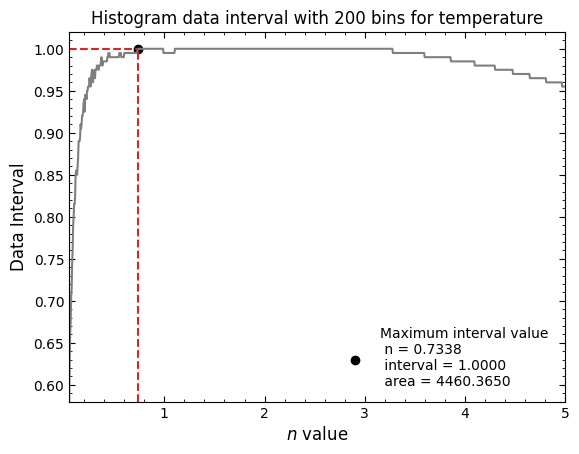

In [11]:
# This  analyzes histogram intervals for temperature data.
# It transforms the data using a power function (taking the 1/nth power) for a range of n values,
# computes the histogram for each transformed dataset,
# and calculates the "interval" as the sum of the widths of bins that contain nonzero counts.
n_values = np.linspace(0.05, 5, 1000)
bins=200

area_array = []   
intervals = []   

for n_value in n_values:
    if n_value == 0.0:
        continue
    
    data = np.power(temperature, (1 / n_value))
    
    counts, bin_edges = np.histogram(data, bins=bins)

    valids = np.nonzero(counts)[0]
    interval = 0
    for i in valids:
        interval += bin_edges[i + 1] - bin_edges[i]
    intervals.append(interval)

    # Calculate the area under the histogram as the sum of (counts * bin width) for each bin.
    area = np.sum(counts * np.diff(bin_edges))
    area_array.append(area)

max_index = np.argmax(intervals)

plt.plot(n_values, intervals, color="tab:gray")
plt.title(f'Histogram data interval with {bins} bins for temperature')

plt.scatter(n_values[max_index], intervals[max_index], color='k',
            label=f'Maximum interval value \n n = {n_values[max_index]:.4f} \n interval = {intervals[max_index]:.4f} \n area = {area_array[max_index]:.4f}')
plt.vlines(n_values[max_index], min(intervals), max(intervals), linestyles='dashed', color='tab:red')
plt.hlines(max(intervals), min(n_values), n_values[max_index], linestyles='dashed', color='tab:red')

plt.xlim((min(n_values), max(n_values)))
plt.ylim((min(intervals), max(intervals) * 1.02))

plt.xlabel(r'$n$ value')
plt.ylabel(r'Data Interval')

plt.legend(loc='lower right')
plt.show()

Best n: 2.52 with maximum area: 4460.37 over interval: (np.float64(0.0), np.float64(1.0))


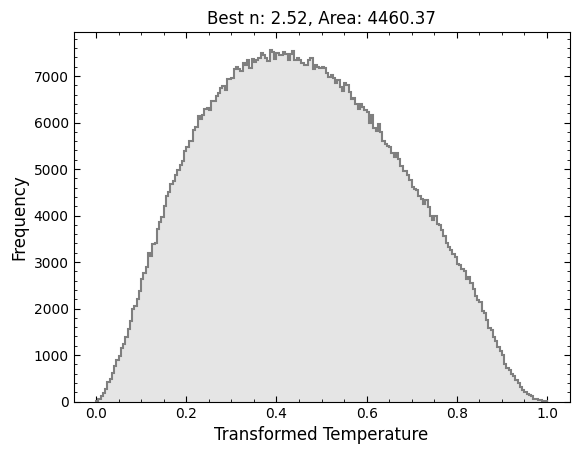

In [12]:
n_values = np.linspace(0.1, 10, 50)

best_area = -np.inf
best_n = None
best_interval = None

for n in n_values:
    transformed = np.power(temperature, 1/n)
    
    # Compute the histogram with a fixed number of bins
    counts, bin_edges = np.histogram(transformed, bins=200)
    
    # Identify bins with non-zero counts (valid bins)
    valid_indices = np.nonzero(counts)[0]
    if valid_indices.size == 0:
        continue 
    
    # The valid interval is defined from the left edge of the first valid bin
    # to the right edge of the last valid bin.
    lower_bound = bin_edges[valid_indices[0]]
    upper_bound = bin_edges[valid_indices[-1] + 1]
    
    # Compute the width of each bin from the full bin_edges array.
    widths = np.diff(bin_edges)
    
    # Calculate the area only over the valid bins.
    area_valid = np.sum(counts[valid_indices] * widths[valid_indices])
    
    # Update best if a larger area is found.
    if area_valid > best_area:
        best_area = area_valid
        best_n = n
        best_interval = (lower_bound, upper_bound)

print(f"Best n: {best_n:.2f} with maximum area: {best_area:.2f} over interval: {best_interval}")

transformed_best = np.power(temperature, 1/best_n)
plt.hist(transformed_best, bins=200, histtype="step", color="tab:gray", lw=1.5)
plt.hist(transformed_best, bins=200, color="tab:gray", alpha=0.2)
plt.title(f'Best n: {best_n:.2f}, Area: {best_area:.2f}')
plt.xlabel('Transformed Temperature')
plt.ylabel('Frequency');

## Molecules

In [13]:
def interval_hist_molecules(molecule, n_start = 1, n_end = 20, divs = 1000, bins = 200, plot=True):
    n_values = np.linspace(n_start, n_end, divs)

    area_array = []
    intervals = []

    for n_value in n_values:
        if n_value == 0.0:
            continue
        
        data = np.power(molecules[molecule], (1/n_value))
        
        counts, bin_edges = np.histogram(data, bins=bins)

        valids = np.nonzero(counts)[0]
        interval = 0
        for i in valids:
            interval += bin_edges[i+1] - bin_edges[i]
        intervals.append(interval)

        area = np.sum(counts * np.diff(bin_edges))
        area_array.append(area)

    max_index = np.argmax(intervals)

    plt.plot(n_values, intervals, color="tab:gray")
    plt.title(f'Histogram data interval with {bins} bins for {molecule}')

    plt.scatter(n_values[max_index], intervals[max_index], color = 'k',
                label = f'Maximum interval value \n n = {n_values[max_index]:.4f} \n interval = {intervals[max_index]:.4f} \n area = {area_array[max_index]:.4f}')
    plt.vlines(n_values[max_index], min(intervals), max(intervals), linestyles='dashed', color = 'tab:red')
    plt.hlines(max(intervals), min(n_values), n_values[max_index], linestyles='dashed', color = 'tab:red')

    plt.xlim((min(n_values), max(n_values)))
    plt.ylim((min(intervals), max(intervals)*1.02))

    plt.xlabel(r'$n$ value')
    plt.ylabel(r'Data Interval')

    plt.legend(loc = 'lower right')
    plt.show()


    return n_values[max_index]

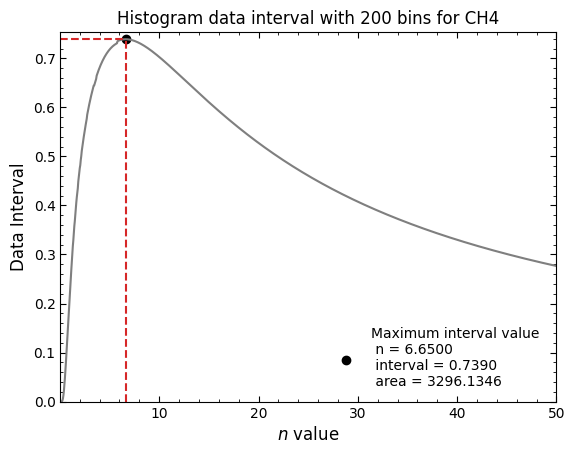

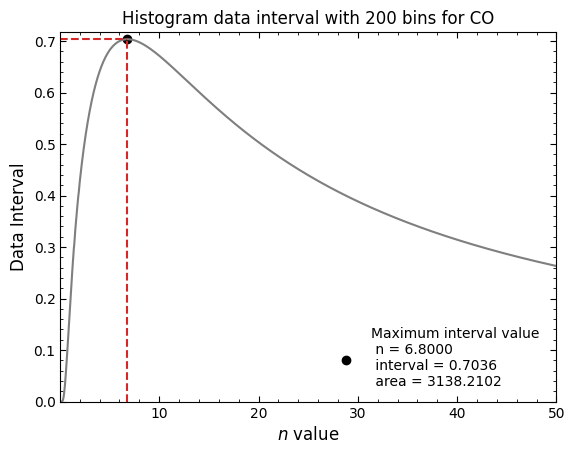

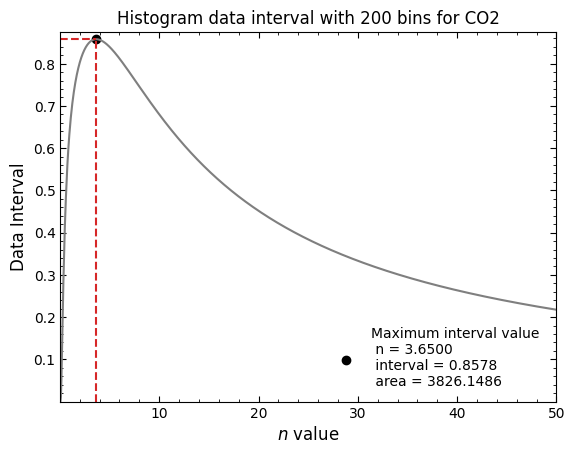

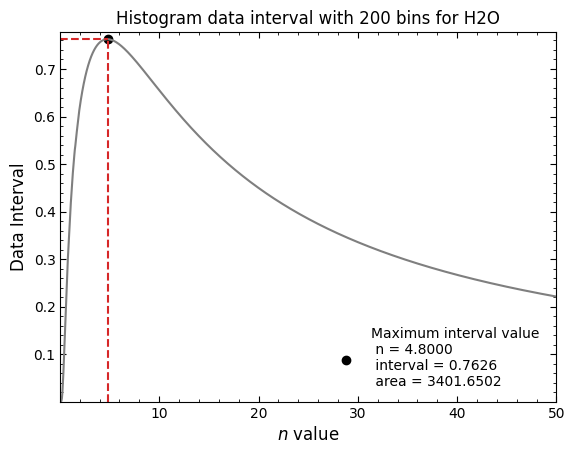

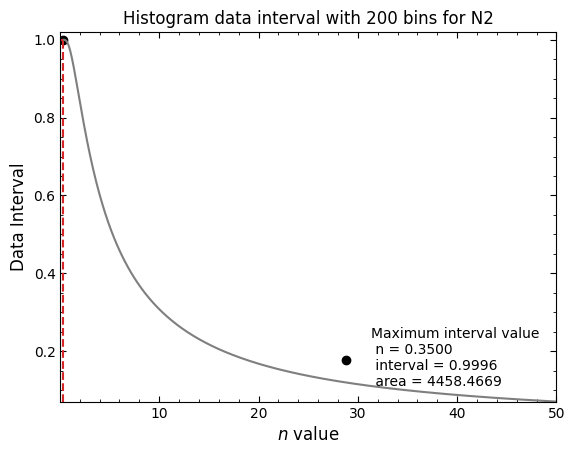

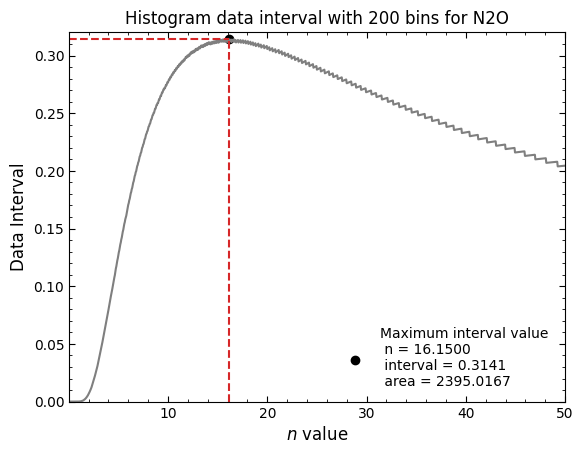

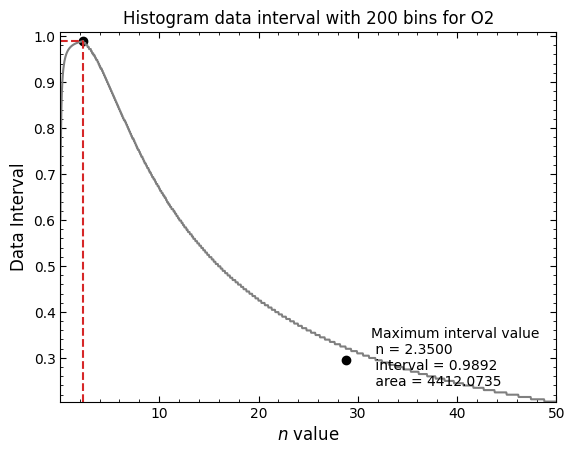

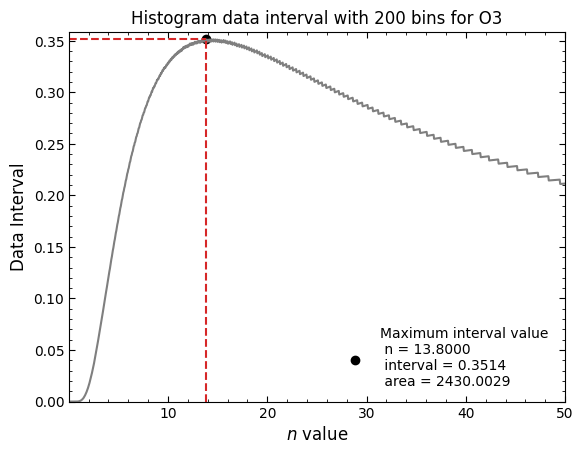

In [14]:
best_n_values = {}

for mol_key in list(molecules.keys()):
    best_n_values[mol_key] = interval_hist_molecules(mol_key, n_start=0.05, n_end=50)

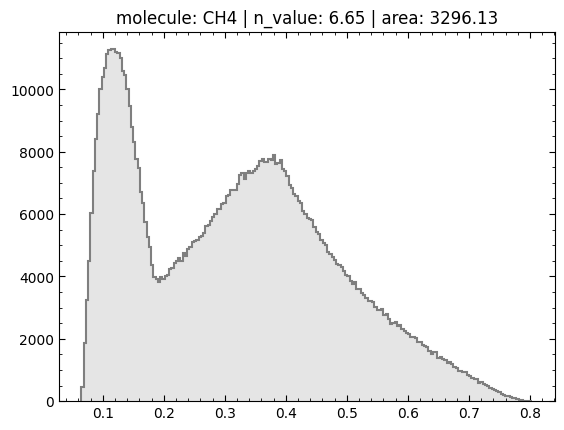

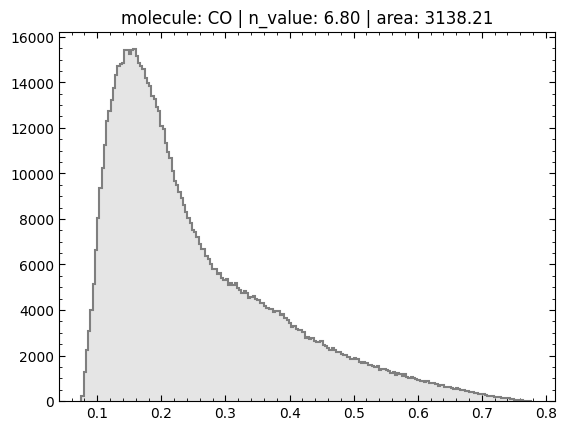

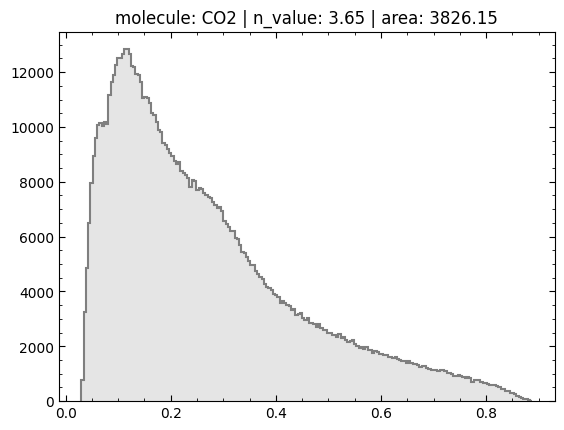

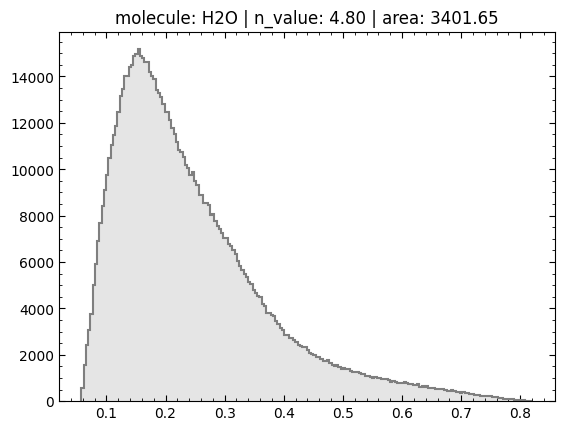

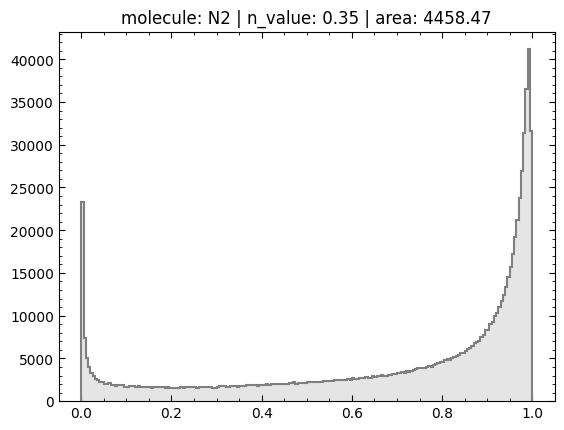

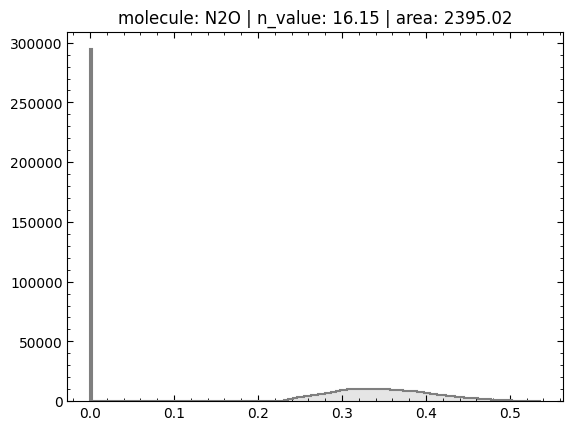

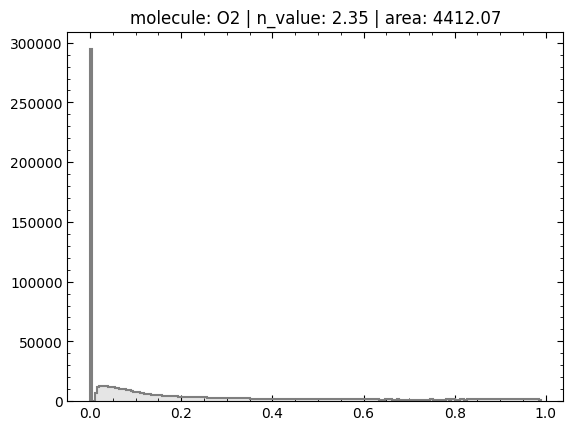

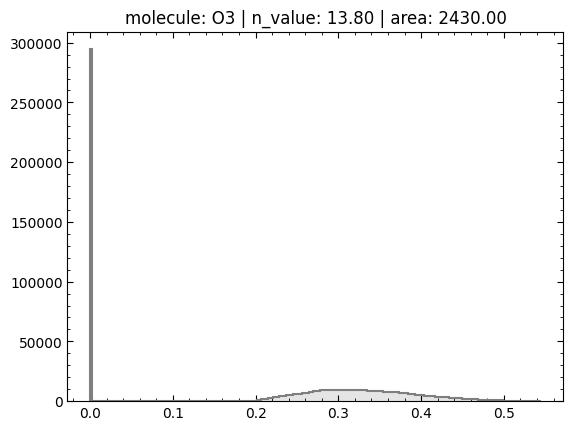

In [15]:
# Let's plot the histograms for each molecule using the best n value
bins = 200

for i, molecule in enumerate(list(molecules.keys())):
    data = np.power(molecules[molecule], (1/best_n_values[molecule]))
    counts, bin_edges = np.histogram(data, bins=bins)
    area = np.sum(counts * np.diff(bin_edges))
    
    plt.hist(data, bins=bins, histtype="step", color="tab:gray", lw=1.5)
    plt.hist(data, bins=bins, color="tab:gray", alpha=0.2)
    plt.title(f'molecule: {molecule} | n_value: {best_n_values[molecule]:.2f} | area: {area:.2f}')
    # plt.ylim((0, 2000))
    plt.show()

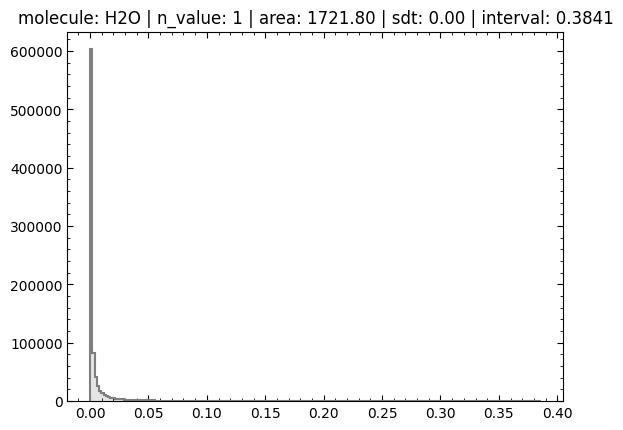

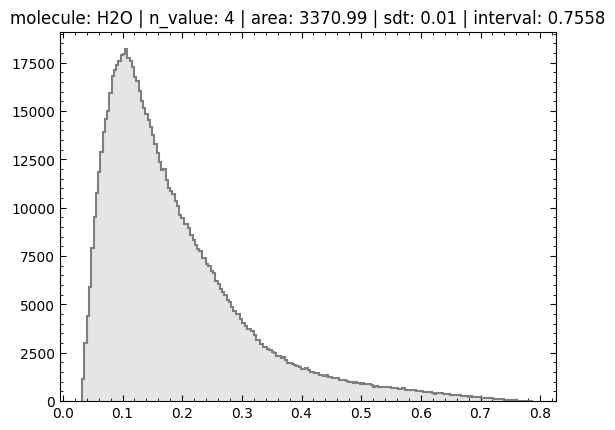

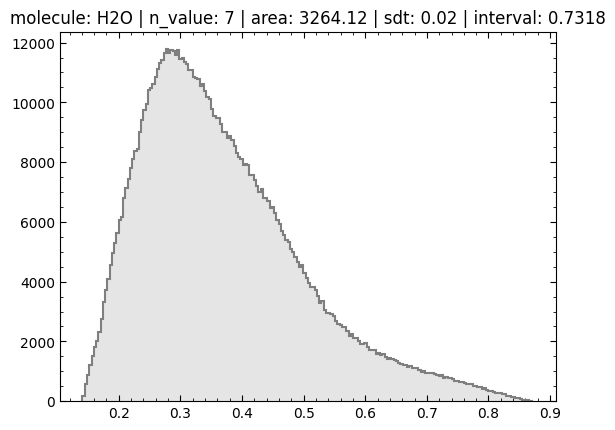

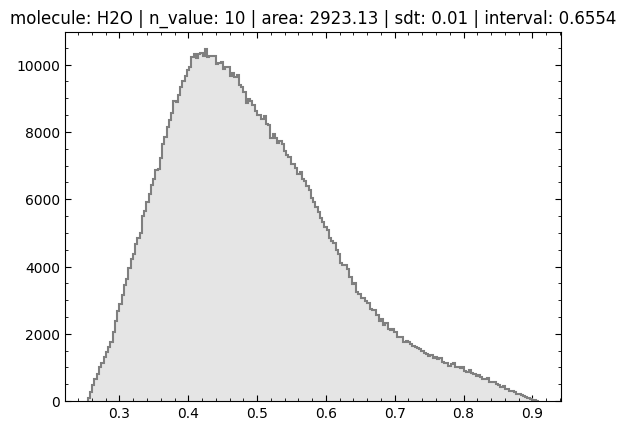

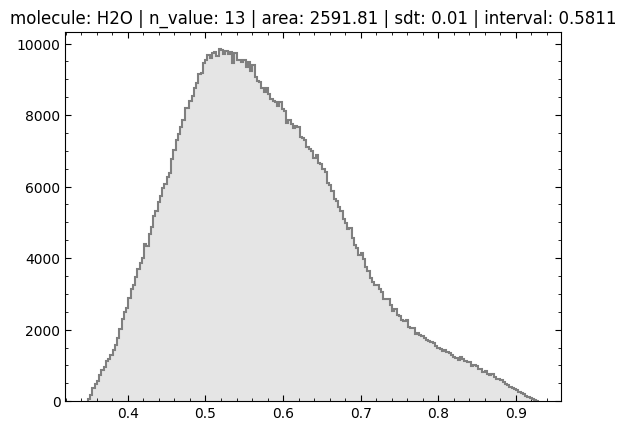

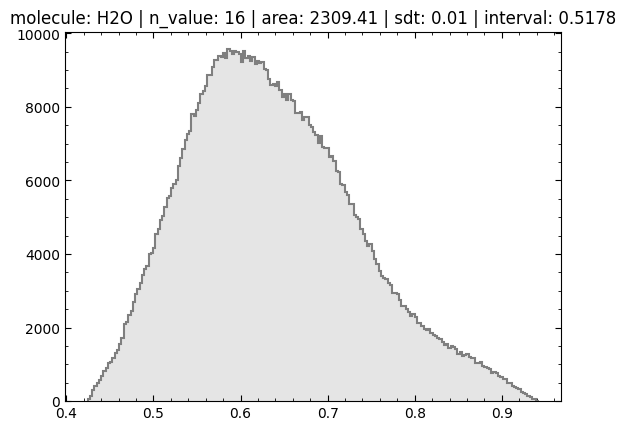

In [16]:
# Let's see how a power transformation with different n values affects 
# the histogram of the H2O molecule
n_values = np.arange(1,17,3)
molecule = 'H2O'
bins = 200

for n_value in n_values:
    data = np.power(molecules[molecule], (1/n_value))
    counts, bin_edges = np.histogram(data, bins=bins)

    valids = np.nonzero(counts)[0]
    interval = 0
    for i in valids:
        interval += bin_edges[i+1] - bin_edges[i]

    area = np.sum(counts * np.diff(bin_edges))

    spread_std = np.std(data)**2
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    plt.hist(data, bins=bins, histtype="step", color="tab:gray", lw=1.5)
    plt.hist(data, bins=bins, color="tab:gray", alpha=0.2)
    plt.title(f'molecule: {molecule} | n_value: {n_value} | area: {area:.2f} | sdt: {spread_std:.2f} | interval: {interval:.4f}')
    # plt.ylim((0, 2000))
    plt.show()

In [18]:
best_n_values["Temperature"] = best_n
best_n_values

{'CH4': np.float64(6.65),
 'CO': np.float64(6.8),
 'CO2': np.float64(3.65),
 'H2O': np.float64(4.8),
 'N2': np.float64(0.35000000000000003),
 'N2O': np.float64(16.150000000000002),
 'O2': np.float64(2.35),
 'O3': np.float64(13.8),
 'Temperature': np.float64(2.5244897959183676)}

The function examines how a power transformation affects the data's distribution. For each $ n $ in a specified range, it transforms the original data $ x $ using the relation $ y = x^{\frac{1}{n}} $, thereby altering its distribution. It then computes a histogram of the transformed data by dividing it into a fixed number of bins. From the histogram, two key quantities are calculated: an "interval" and an "area." The interval is defined as the sum of the widths of all bins that contain at least one data point, which can be mathematically expressed as

$
\text{Interval}(n) = \sum_{i: \text{count}_i > 0} (b_{i+1} - b_i),
$

where $ b_i $ are the bin edges and $\text{count}_i$ are the counts in each bin. In parallel, the area under the histogram is computed as

$
\text{Area}(n) = \sum_{i} \text{count}_i \cdot (b_{i+1} - b_i),
$

which represents a Riemann sum approximation of the integral of the histogram. This area essentially approximates the total "weight" or cumulative frequency of the data across its range. The function then identifies the value of $ n $ that maximizes the interval, meaning that the transformed data achieves the widest spread or support. This optimal $ n $ is both highlighted in the plot and returned, providing a parameter choice that best reveals the underlying structure of the data.

# Plotting the figures to the paper

In [19]:
def hist_interval(data_array, n_start = 1, n_end = 20, divs = 1000, bins = 200):
    # The same function of interval_hist_molecules but for a unique data array
    n_values = np.linspace(n_start, n_end, divs)

    area_array = []
    intervals = []

    for n_value in n_values:
        if n_value == 0.0:
            continue
        
        data = np.power(data_array, (1/n_value))
        
        counts, bin_edges = np.histogram(data, bins=bins)

        valids = np.nonzero(counts)[0]
        interval = 0
        for i in valids:
            interval += bin_edges[i+1] - bin_edges[i]
        intervals.append(float(interval))

        area = np.sum(counts * np.diff(bin_edges))
        area_array.append(area)

    return n_values, np.array(intervals)

In [20]:
def format_molecule(molecule):
    return re.sub(r'(\d+)', r'$_{\1}$', molecule)

def plt_n_inspection_species(species_dict, save=False):
    n_species = len(species_dict)
    bins = 100
    
    _, axs = plt.subplots(n_species, 3, figsize=(11, 3 * n_species))
    
    if n_species == 1:
        axs = np.array([axs])
    
    for idx, (molecule, sp_info) in enumerate(species_dict.items()):
        data = sp_info['data']
        best_n = sp_info['best_n']
        
        # Format molecule notation for display
        molecule_label = format_molecule(molecule)
        
        # Analyse histogram interval over a range of n values.
        n_values, intervals = hist_interval(data, n_start=0.05, n_end=50)
        max_index = np.argmax(intervals)
        
        # Plot 1: Original Data Histogram
        ax = axs[idx, 0]
        ax.hist(data, bins=bins, color="k", histtype="step")
        ax.hist(data, bins=bins, color="k", alpha=0.8)
        ax.set_title(f'{molecule_label} - Original data')
        if idx == n_species - 1:
            ax.set_xlabel("Raw data value")
        else:
            ax.set_xlabel("")
        ax.set_ylabel("Counts")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
        # Plot 2: Histogram Interval Analysis
        ax = axs[idx, 1]
        ax.plot(n_values, intervals, color="k")
        ax.scatter(n_values[max_index], intervals[max_index],
                    color='k', label=f'Max: n = {best_n:.2f}')
        ax.vlines(n_values[max_index], min(intervals), max(intervals),
                    linestyles='dashed', color='tab:red')
        ax.hlines(max(intervals), min(n_values), n_values[max_index],
                    linestyles='dashed', color='tab:red')
        ax.set_xlim((min(n_values), max(n_values)))
        ax.set_ylim((min(intervals), max(intervals)*1.02))
        ax.set_title(f'{molecule_label} - Histogram interval')
        if idx == n_species - 1:
            ax.set_xlabel("$n$ value")
        else:
            ax.set_xlabel("")
        ax.set_ylabel("Valid interval width")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.ticklabel_format(axis='x', style='sci')
        ax.legend()
        
        # Plot 3: Transformed Data Histogram
        ax = axs[idx, 2]
        transformed_data = np.power(data, 1 / best_n)
        ax.hist(transformed_data, bins=bins, color="k", histtype="step")
        ax.hist(transformed_data, bins=bins, color="tab:gray", alpha=0.2)
        ax.set_title(f'{molecule_label} - Transformed data (n = {best_n:.2f})')
        if idx == n_species - 1:
            ax.set_xlabel("Transformed data value")
        else:
            ax.set_xlabel("")
        ax.set_ylabel("Counts")
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=False)
    
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=200)
    plt.show()

In [21]:
species = {
    'CH4': {'data': molecules['CH4'], 'best_n': 6.65},
    # 'CO': {'data': molecules['CO'], 'best_n': 6.8},
    # 'CO2' : {'data': molecules['CO2'], 'best_n': 3.65},
    # 'H2O' : {'data': molecules['H2O'], 'best_n': 4.8},
    'N2' : {'data': molecules['N2'], 'best_n': 0.35},
    # 'N2O' : {'data': molecules['N2O'], 'best_n': 16.15},
    # 'O2' : {'data': molecules['O2'], 'best_n': 2.35},
    'O3' : {'data': molecules['O3'], 'best_n': 13.8},
}

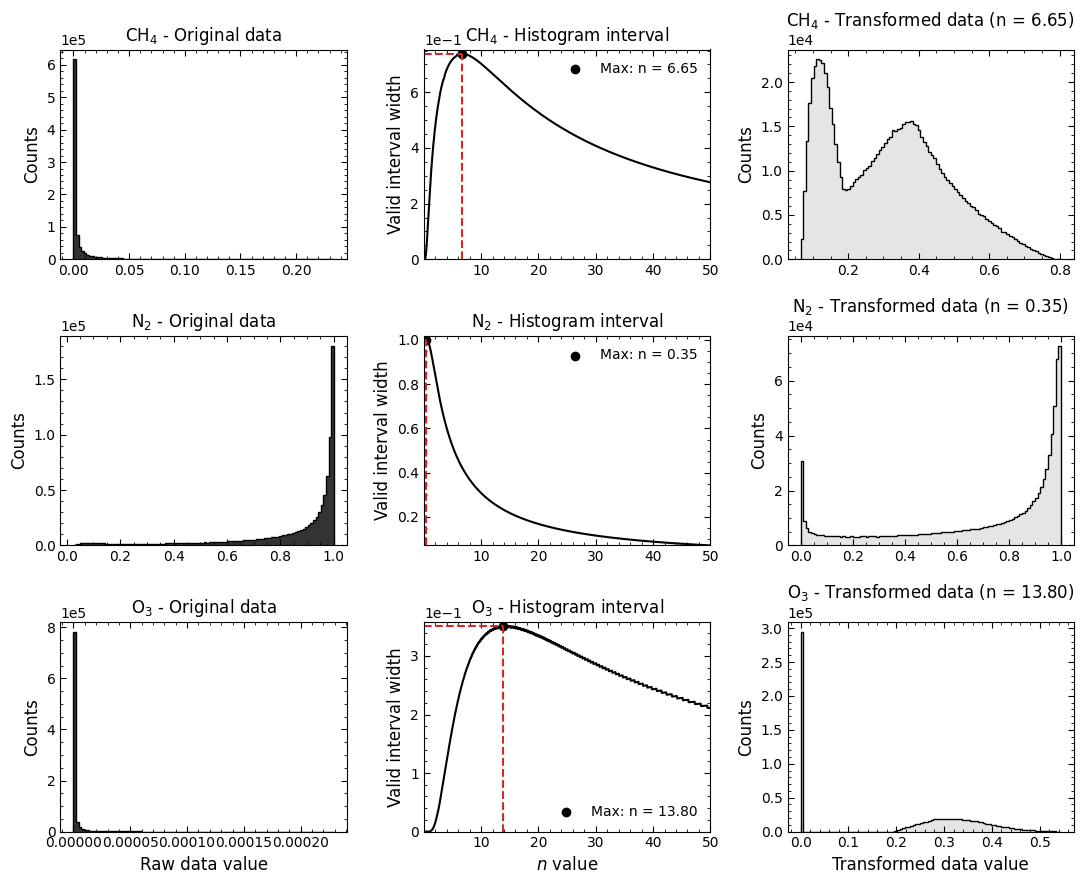

In [22]:
plt_n_inspection_species(species, save='../images/selected_species_n_value.pdf')